<a href="https://colab.research.google.com/github/kkfwees/cs230_2020/blob/master/CS230_RCNN_Logistics_Supply_Detection_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: get needed packages and mount the google drive


In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lr0r6uwv
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lr0r6uwv
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267012 sha256=67f756729445f5c7f62a806c59eb09ba0504e9fdb7b21d1696502e9babc2e9f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-qzwfup55/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.0
    Uninstalling pycocotools-2.0.0:
      Successfully uninstalled pycocotools-2.0.0


In [0]:
#get all needed resources
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import numpy as np
import torch
import torch.utils.data

In [3]:
# mount data to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Step 1: training the model baseline model (Model 1)
That is, the dataset with incomplete labels

Check: run to check if the image directories and the mask directories match:

In [0]:
#check length of different data dictories: they should match
#if this does not run: create a shortcut to Eleni Shared CS230 drive 
print(len(os.listdir('/content/drive/My Drive/CS230/data/brural/masks')))
print(len(os.listdir('/content/drive/My Drive/CS230/data/brural/unlabeled')))

print(len(os.listdir('/content/drive/My Drive/CS230/data/bpop150k/masks')))
print(len(os.listdir('/content/drive/My Drive/CS230/data/bpop150k/unlabeled')))

print(len(os.listdir('/content/drive/My Drive/CS230/data/bpop1000k/masks')))
print(len(os.listdir('/content/drive/My Drive/CS230/data/bpop1000k/unlabeled')))

print(len(os.listdir('/content/drive/My Drive/CS230/data/bpopunlmtd/masks')))
print(len(os.listdir('/content/drive/My Drive/CS230/data/bpopunlmtd/unlabeled')))

#check if imgs and masks match
mask_files = os.listdir('/content/drive/My Drive/CS230/data/bpop1000k/masks')
imgs_files = os.listdir('/content/drive/My Drive/CS230/data/bpop1000k/unlabeled')

for i in range(len(imgs_files)):
  temp_string = imgs_files[i].split("_", 4)
  temp_string = temp_string[0]+"_"+temp_string[1]+"_"+temp_string[2] +"_"+temp_string[3][:-4] 
  imgs_files[i] = temp_string

for i in range(len(mask_files)):
  temp_string = mask_files[i].split("_", 4)
  temp_string = temp_string[0]+"_"+temp_string[1]+"_"+temp_string[2] +"_"+temp_string[3]
  mask_files[i] = temp_string

missing_masks = []

for i in range(len(imgs_files)):
  if imgs_files[i] not in mask_files:
     missing_masks.append(imgs_files[i])

missing_imgs = []

for i in range(len(mask_files)):
  if mask_files[i] not in imgs_files:
     missing_imgs.append(mask_files[i])

print(missing_masks)
print(missing_imgs)

2001
2001
647
647
2289
2289
638
638
[]
[]


Example: run to see how the dataset class works:

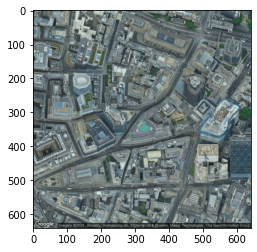

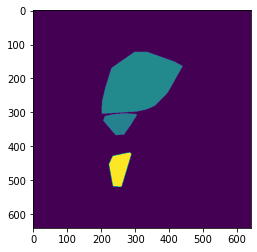

[  0  96 104 218]
[[206, 303, 304, 366], [202, 123, 438, 303], [223, 418, 288, 518]]


In [0]:
#test the datasest class
test_img = Image.open('/content/drive/My Drive/CS230/data/bpop150k/unlabeled/367_2_640x640_bpop150k.png').convert("RGB")
plt.imshow(test_img)
plt.show()
test_mask = Image.open('/content/drive/My Drive/CS230/data/bpop150k/masks/367_2_640x640_bpop150k_labeled.png').convert("L")
plt.imshow(test_mask)
plt.show()

test_mask = np.array(test_mask)
# instances are encoded as different colors
test_obj_ids = np.unique(test_mask)
print(test_obj_ids)

# first id is the background, so remove it
test_obj_ids = test_obj_ids[1:]

test_masks = test_mask == test_obj_ids[:, None, None]

# get bounding box coordinates for each mask
test_num_objs = len(test_obj_ids)
test_boxes = []
for i in range(test_num_objs):
    pos = np.where(test_masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    test_boxes.append([xmin, ymin, xmax, ymax])


print(test_boxes)


In [0]:
class SatelliteDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root,  "/content/drive/My Drive/CS230/data/bpop150k/unlabeled"))))
        self.imgs += list(sorted(os.listdir(os.path.join(root,  "/content/drive/My Drive/CS230/data/brural/unlabeled"))))
        self.imgs += list(sorted(os.listdir(os.path.join(root,  "/content/drive/My Drive/CS230/data/bpop1000k/unlabeled"))))
        self.imgs += list(sorted(os.listdir(os.path.join(root,  "/content/drive/My Drive/CS230/data/bpopunlmtd/unlabeled"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "/content/drive/My Drive/CS230/data/bpop150k/masks"))))
        self.masks += list(sorted(os.listdir(os.path.join(root, "/content/drive/My Drive/CS230/data/brural/masks"))))
        self.masks += list(sorted(os.listdir(os.path.join(root, "/content/drive/My Drive/CS230/data/bpop1000k/masks"))))
        self.masks += list(sorted(os.listdir(os.path.join(root, "/content/drive/My Drive/CS230/data/bpopunlmtd/masks"))))


    def __getitem__(self, idx):
        # load images and masks

        if self.imgs[idx].__contains__('bpop150k'):
          img_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/bpop150k/unlabeled", self.imgs[idx])
          mask_path = os.path.join(self.root, "/content/drive/My Drive/CS230/data/bpop150k/masks", self.masks[idx])
        elif self.imgs[idx].__contains__('brural'):
          img_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/brural/unlabeled", self.imgs[idx])
          mask_path = os.path.join(self.root, "/content/drive/My Drive/CS230/data/brural/masks", self.masks[idx])
        elif self.imgs[idx].__contains__('bpop1000k'):
          img_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/bpop1000k/unlabeled", self.imgs[idx])
          mask_path = os.path.join(self.root, "/content/drive/My Drive/CS230/data/bpop1000k/masks", self.masks[idx])
        else:
          img_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/bpopunlmtd/unlabeled", self.imgs[idx])
          mask_path = os.path.join(self.root, "/content/drive/My Drive/CS230/data/bpopunlmtd/masks", self.masks[idx])
        
        img = Image.open(img_path).convert("RGB")
        
  
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        # mask = Image.open(mask_path)
        #mask = np.array(mask)
        #print(mask.shape)
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            test_area = (ymax-ymin) * (xmax-xmin)
            if test_area > 0:
              boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

check: another check if the dasaset class correctly matches all images with masks

In [0]:
#2nd check if imgs and masks match
test_dataset = SatelliteDataset('/content/drive/My Drive/CS230/data')
print(len(test_dataset.imgs))
img_list = []
for i in range(len(test_dataset.imgs)):
  temp_string = test_dataset.imgs[i].split("_", 4)
  temp_string = temp_string[0]+"_"+temp_string[1]+"_"+temp_string[2] +"_"+temp_string[3][:-4] 
  img_list.append(temp_string)

mask_list = []
for i in range(len(test_dataset.masks)):
  temp_string = test_dataset.masks[i].split("_", 4)
  temp_string = temp_string[0]+"_"+temp_string[1]+"_"+temp_string[2] +"_"+temp_string[3]
  mask_list.append(temp_string)


missing_masks = []

for i in range(len(test_dataset.imgs)):
  if img_list[i] not in mask_list:
    missing_masks.append(img_list[i])

missing_imgs = []

for i in range(len(test_dataset.masks)):
  if mask_list[i] not in img_list:
    missing_imgs.append(mask_list[i])

5575


In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8393 (delta 1), reused 1 (delta 0), pack-reused 8391
Receiving objects: 100% (8393/8393), 10.25 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (5778/5778), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# use our dataset and defined transformations
dataset = SatelliteDataset('/content/drive/My Drive/CS230/data', get_transform(train=True))
dataset_test = SatelliteDataset('/content/drive/My Drive/CS230/data', get_transform(train=False))
dataset_test_final = SatelliteDataset('/content/drive/My Drive/CS230/data', get_transform(train=False))


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-1000])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-1000:-100])
dataset_test_final = torch.utils.data.Subset(dataset_test_final, indices[-100:])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)


In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)



Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [0]:
# get pretrained weights
model.load_state_dict(torch.load('/content/drive/My Drive/CS230/parameters/RCNN_v3 (west_eu)/paramsrcnnv3westeu_epoch8.pth'))

<All keys matched successfully>

In [0]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
# let's train it for 10 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1000)
    # update the learning rate
    lr_scheduler.step()

    #save parameters to latest pth file
    torch.save(model.state_dict(), '/content/drive/My Drive/CS230/parameters/RCNN_v3 (west_eu)/paramsrcnnv3westeu_epoch' + str(epoch+9) +'.pth')

    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [   0/4575]  eta: 2:33:49  lr: 0.000001  loss: 0.3251 (0.3251)  loss_classifier: 0.0961 (0.0961)  loss_box_reg: 0.0104 (0.0104)  loss_mask: 0.1915 (0.1915)  loss_objectness: 0.0223 (0.0223)  loss_rpn_box_reg: 0.0046 (0.0046)  time: 2.0173  data: 1.1313  max mem: 957
Epoch: [0]  [1000/4575]  eta: 1:01:01  lr: 0.000500  loss: 0.2686 (0.3978)  loss_classifier: 0.0747 (0.0945)  loss_box_reg: 0.0147 (0.0295)  loss_mask: 0.1827 (0.2563)  loss_objectness: 0.0063 (0.0110)  loss_rpn_box_reg: 0.0049 (0.0064)  time: 0.9951  data: 0.7554  max mem: 1481
Epoch: [0]  [2000/4575]  eta: 0:43:49  lr: 0.000500  loss: 0.2517 (0.3900)  loss_classifier: 0.0645 (0.0963)  loss_box_reg: 0.0133 (0.0299)  loss_mask: 0.1546 (0.2463)  loss_objectness: 0.0036 (0.0109)  loss_rpn_box_reg: 0.0028 (0.0066)  time: 0.9943  data: 0.7520  max mem: 1491
Epoch: [0]  [3000/4575]  eta: 0:26:45  lr: 0.000500  loss: 0.2278 (0.3801)  loss_classifier: 0.0515 (0.0934)  loss_box_reg: 0.0082 (0.0289)  loss_mask: 0.1475 (0

# Step 2: update labels using predictions from the baseline model

In [0]:
# pick one image from the test set 
dataset_relabel = SatelliteDataset('/content/drive/My Drive/CS230/data', get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_relabel = torch.utils.data.Subset(dataset_relabel, indices[:-1000])
num_dataset_relabel = len(dataset_relabel)

img, temp_target = dataset_relabel[60]
temp_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [0]:
#create labeled imaged for error analysis + suggestions for human label corrections

for k in range(0,100):
  # pick one image from the test set 
  img, temp_target = dataset_test_final[k]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])

  #run non-max supression
  nms_indices = torchvision.ops.nms(prediction[0]['boxes'], prediction[0]['scores'], 0.25)
  nms_indices = np.asarray(nms_indices.cpu()).astype(int)
  nms_indices.reshape((1, -1))

  #draw bounding box predicted by the model
  tmp_boxes = np.round(np.asarray(prediction[0]['boxes'].cpu()))
  temp_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  temp_draw  = ImageDraw.Draw(temp_img)
  tmp_boxes.shape[0]
  for i in nms_indices:
    #red color for confident predictions
    if np.asscalar(prediction[0]['scores'][i].cpu()) > 0.5:
      temp_draw.rectangle([(tmp_boxes[i,0],tmp_boxes[i,1]), (tmp_boxes[i,2],tmp_boxes[i,3])], fill=None, outline="red")
    #orange color for semi-confident predictions
    else:
      temp_draw.rectangle([(tmp_boxes[i,0],tmp_boxes[i,1]), (tmp_boxes[i,2],tmp_boxes[i,3])], fill=None, outline="orange")

  #draw google labeled bounding box 
  tmp_boxes = np.round(np.asarray(temp_target['boxes'].cpu()))
  for i in range(tmp_boxes.shape[0]):
    temp_draw.rectangle([(tmp_boxes[i,0],tmp_boxes[i,1]), (tmp_boxes[i,2],tmp_boxes[i,3])], fill=None, outline="yellow")

  #temp_img_id = str(np.asarray(temp_target['image_id'])).replace("[","").replace("]","")
  #temp_img.save("/content/drive/My Drive/CS230/data/self_labeled/img_" + temp_img_id +".PNG")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [0]:
#create new labels for next round of training
for k in range(0,num_dataset_relabel):
  # pick one image from the test set 
  img, temp_target = dataset_relabel[k]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])

  #start orginal unlabeled picutre and make it black and turn it into array
  #skip making zero's if you want to overlay label on orginal picture
  new_mask_img = img.mul(255).permute(1, 2, 0).byte().numpy()
  new_mask_img[:,:,0]= 0
  new_mask_img[:,:,1]= 0
  new_mask_img[:,:,2]= 0

  #determine which prediction overlap/correspond with the orginal, those should not be added as new masks
  num_boxes = prediction[0]['boxes'].cpu().shape[0]
  num_orig_boxes = temp_target['boxes'].shape[0]
  scores_orig_boxes = torch.ones((num_orig_boxes), dtype=torch.float32)
  concat_boxes = torch.cat((prediction[0]['boxes'].cpu(), temp_target['boxes']),0)
  concat_scores = torch.cat((prediction[0]['scores'].cpu(), scores_orig_boxes),-1)
  keep_pred = torchvision.ops.nms(concat_boxes, concat_scores, 0.5)

  #check number of mask orginally and in the prediction
  num_masks = np.asarray(prediction[0]['masks'].cpu()).shape[0]
  num_masks_orig = np.asarray(temp_target['masks']).shape[0]

  #add orignal masks
  for i in range(0,num_masks_orig):
    np.random.seed(0) 
    r_channel = np.random.uniform(low=0, high=255, size=num_masks_orig).astype(int)
    np.random.seed(1) 
    g_channel = np.random.uniform(low=0, high=255, size=num_masks_orig).astype(int)
    np.random.seed(2) 
    b_channel = np.random.uniform(low=0, high=255, size=num_masks_orig).astype(int)
    orig_mask = np.asarray(temp_target['masks'])[i]
    new_mask_img[:,:,0][orig_mask==1] = r_channel[i]
    new_mask_img[:,:,1][orig_mask==1] = g_channel[i]
    new_mask_img[:,:,2][orig_mask==1] = b_channel[i]

  #add predicted masks
  for i in range(0,num_masks):
    np.random.seed(3) 
    r_channel = np.random.uniform(low=0, high=255, size=num_masks).astype(int)
    np.random.seed(4) 
    g_channel = np.random.uniform(low=0, high=255, size=num_masks).astype(int)
    np.random.seed(5) 
    b_channel = np.random.uniform(low=0, high=255, size=num_masks).astype(int)
    if (prediction[0]['scores'][i] > 0.5) and (i in keep_pred):
      new_mask = prediction[0]['masks'][i, 0]
      new_mask[new_mask >= 0.5] = 1
      new_mask[new_mask < 0.5] = 0
      new_mask_img[:,:,0][new_mask.cpu()==1] = r_channel[i]
      new_mask_img[:,:,1][new_mask.cpu()==1] = g_channel[i]
      new_mask_img[:,:,2][new_mask.cpu()==1] = b_channel[i]

  #make image of new mask
  new_mask_img = Image.fromarray(new_mask_img)

  temp_img_id = str(np.asarray(temp_target['image_id'])).replace("[","").replace("]","")
  new_mask_img.save("/content/drive/My Drive/CS230/data/west_eu_model_labels/iteration_1/" + str(k) + ".PNG")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


# Step 3: train Model 4, i.e. new model with the relabeded images + additional images with no logistics instances

In [0]:
class RelabeledDataset(torch.utils.data.Dataset):
    def __init__(self, root, prev_data, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.prev_data = prev_data
        self.imgs = list(np.arange(0, len(self.prev_data)))
        self.masks = list(np.arange(0, len(self.prev_data)))
        self.imgs += list(sorted(os.listdir(os.path.join(root,  "/content/drive/My Drive/CS230/data/non_logistics_final/augmented_non_logistics/unlabeled")))) 
        self.masks += list(sorted(os.listdir(os.path.join(root,  "/content/drive/My Drive/CS230/data/non_logistics_final/augmented_non_logistics/masks"))))  
        

    def __getitem__(self, idx):
        # load images and masks


        if idx < len(self.prev_data): #logistics images
          mask_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/west_eu_model_labels/iteration_1", str(idx)+'.PNG')
          img, _ = self.prev_data[idx]
          img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())  
        else: #nonlogistics images
          img_path = os.path.join(self.root,  "/content/drive/My Drive/CS230/data/non_logistics_final/augmented_non_logistics/unlabeled", self.imgs[idx])
          mask_path = os.path.join(self.root, "/content/drive/My Drive/CS230/data/non_logistics_final/augmented_non_logistics/masks", self.masks[idx]) 
          img = Image.open(img_path).convert("RGB")    
  
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            test_area = (ymax-ymin) * (xmax-xmin)
            if test_area > 0:
              boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
# init prev data
dataset_relabel = SatelliteDataset('/content/drive/My Drive/CS230/data', get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(dataset_relabel)).tolist()
dataset_relabel = torch.utils.data.Subset(dataset_relabel, indices[:-1000])

In [0]:
# use our dataset and defined transformations
dataset2 = RelabeledDataset('/content/drive/My Drive/CS230/data',dataset_relabel, get_transform(train=True))

# define training and validation data loaders
data_loader2 = torch.utils.data.DataLoader(
    dataset2, batch_size=1, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)


In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model2 = get_instance_segmentation_model(num_classes)
# move model to the right device
model2.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [29]:
# get pretrained weights
model2.load_state_dict(torch.load('/content/drive/My Drive/CS230/parameters/RCNN_v3 (west_eu)/paramsrcnnv3westeu_model2bxnonlogis_epoch2.pth'))

<All keys matched successfully>

In [0]:
# construct an optimizer
params2 = [p for p in model2.parameters() if p.requires_grad]
optimizer2 = torch.optim.SGD(params2, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2,
                                               step_size=3,
                                               gamma=0.1)

In [31]:
# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model2, optimizer2, data_loader2, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler2.step()

    #save parameters to latest pth file
    torch.save(model2.state_dict(), '/content/drive/My Drive/CS230/parameters/RCNN_v3 (west_eu)/paramsrcnnv3westeu_model2bxnonlogis900_epoch' + str(epoch+2) +'.pth')

    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [   0/5463]  eta: 3:38:43  lr: 0.000001  loss: 0.1791 (0.1791)  loss_classifier: 0.0258 (0.0258)  loss_box_reg: 0.0083 (0.0083)  loss_mask: 0.1251 (0.1251)  loss_objectness: 0.0151 (0.0151)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 2.4023  data: 2.2294  max mem: 1484
Epoch: [0]  [ 100/5463]  eta: 4:00:55  lr: 0.000051  loss: 0.2959 (1.3061)  loss_classifier: 0.0674 (0.0860)  loss_box_reg: 0.0264 (0.0386)  loss_mask: 0.1604 (0.3028)  loss_objectness: 0.0102 (0.5853)  loss_rpn_box_reg: 0.0076 (0.2934)  time: 2.1722  data: 2.0009  max mem: 2005
Epoch: [0]  [ 200/5463]  eta: 3:27:24  lr: 0.000101  loss: 0.3410 (1.2611)  loss_classifier: 0.0746 (0.0843)  loss_box_reg: 0.0319 (0.0404)  loss_mask: 0.1734 (0.3150)  loss_objectness: 0.0252 (0.5466)  loss_rpn_box_reg: 0.0120 (0.2748)  time: 1.9432  data: 1.7704  max mem: 2005
Epoch: [0]  [ 300/5463]  eta: 3:15:23  lr: 0.000151  loss: 0.2842 (1.1453)  loss_classifier: 0.0206 (0.0699)  loss_box_reg: 0.0103 (0.0343)  loss_mask: 0.1699 (